# Apply ARIMA to Weather Data
Assume user downloaded archive.zip from Kaggle,
renamed the file BuildingData.zip,
and stored the file in the data subdirectory.
Assume the zip file contains the weather.csv file.  

In [1]:
DATAPATH=''
try:
    # On Google Drive, set path to my drive / data directory.
    from google.colab import drive
    IN_COLAB = True
    PATH='/content/drive/'
    drive.mount(PATH)
    DATAPATH=PATH+'My Drive/data/'  # must end in "/"
except:
    # On home computer, set path to local data directory.
    IN_COLAB = False
    DATAPATH='data/'  # must end in "/"

ZIP_FILE='BuildingData.zip'
ZIP_PATH = DATAPATH+ZIP_FILE
WEATHER_FILE='weather.csv'
MODEL_FILE='Model'  # will be used later to save models

In [2]:
from os import listdir
import csv
from zipfile import ZipFile
import numpy as np
import pandas as pd
from pandas.plotting import autocorrelation_plot

from sklearn.decomposition import PCA, KernelPCA
from sklearn.preprocessing import StandardScaler

from statsmodels.tsa.arima.model import ARIMA

import matplotlib.pyplot as plt
from matplotlib import colors
mycmap = colors.ListedColormap(['red','blue'])  # list color for label 0 then 1
np.set_printoptions(precision=2)

In [3]:
def read_zip_to_panda(zip_filename,csv_filename):
    zip_handle = ZipFile(zip_filename)
    csv_handle = zip_handle.open(csv_filename)
    panda = pd.read_csv(csv_handle)
    return panda

## Weather data
We have 2 years of hourly weather data per site ID.  
A site is a geographical area such as a college campus.  
Each site is code-named with an animal like Bear.
For each site, we have multiple buildings.  
Each building is code-named with person-name like Lulu.  

In [4]:
wet_df = read_zip_to_panda(ZIP_PATH,WEATHER_FILE)

In [5]:
wet_df

,timestamp,site_id,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
0,2016-01-01 00:00:00,Panther,19.4,NaN,19.4,0.0,NaN,NaN,0.0,0.0
1,2016-01-01 01:00:00,Panther,21.1,6.0,21.1,-1.0,NaN,1019.4,0.0,0.0
2,2016-01-01 02:00:00,Panther,21.1,NaN,21.1,0.0,NaN,1018.8,210.0,1.5
3,2016-01-01 03:00:00,Panther,20.6,NaN,20.0,0.0,NaN,1018.1,0.0,0.0
4,2016-01-01 04:00:00,Panther,21.1,NaN,20.6,0.0,NaN,1019.0,290.0,1.5
...,...,...,...,...,...,...,...,...,...,...
331161,2017-12-31 19:00:00,Mouse,8.5,NaN,4.8,NaN,NaN,992.3,210.0,8.2
331162,2017-12-31 20:00:00,Mouse,8.5,NaN,4.5,NaN,NaN,992.1,210.0,7.2
331163,2017-12-31 21:00:00,Mouse,8.2,NaN,4.0,NaN,NaN,992.1,230.0,10.3
331164,2017-12-31 22:00:00,Mouse,7.5,NaN,4.3,NaN,NaN,993.7,260.0,12.9


In [6]:
print("Air temp and wind speed: 300K reports.")
wet_df.describe()

Air temp and wind speed: 300K reports.


,airTemperature,cloudCoverage,dewTemperature,precipDepth1HR,precipDepth6HR,seaLvlPressure,windDirection,windSpeed
count,331038.000000,160179.000000,330838.000000,197980.000000,18162.000000,309542.000000,318161.000000,330592.000000
mean,14.235343,1.920907,7.649370,0.955738,13.536560,1016.063498,184.391299,3.569554
std,9.990392,2.550744,9.201438,8.273852,43.801017,8.052463,111.571354,2.335197
min,-28.900000,0.000000,-35.000000,-1.000000,-1.000000,968.200000,0.000000,0.000000
25%,7.800000,0.000000,1.800000,0.000000,0.000000,1011.600000,90.000000,2.100000
50%,14.400000,0.000000,8.500000,0.000000,0.000000,1016.200000,200.000000,3.100000
75%,21.100000,4.000000,13.900000,0.000000,5.000000,1020.900000,280.000000,5.000000
max,48.300000,9.000000,26.700000,597.000000,770.000000,1050.100000,360.000000,24.200000


In [24]:
print("Sites:\n",wet_df.site_id.unique())
print()
print("Weather observations per site:\n",wet_df.site_id.value_counts())

Sites:
 ['Panther' 'Robin' 'Fox' 'Rat' 'Bear' 'Lamb' 'Peacock' 'Moose' 'Gator'
 'Bull' 'Bobcat' 'Crow' 'Shrew' 'Swan' 'Wolf' 'Hog' 'Eagle' 'Cockatoo'
 'Mouse']

Weather observations per site:
 Panther     17544
Gator       17544
Fox         17543
Hog         17542
Bear        17542
Rat         17539
Peacock     17539
Eagle       17536
Swan        17535
Bull        17529
Bobcat      17525
Mouse       17516
Shrew       17516
Robin       17516
Wolf        17505
Lamb        17500
Cockatoo    16975
Moose       16860
Crow        16860
Name: site_id, dtype: int64


In [25]:
print("Outside Air Temperature observations for one site:")
gator_df = wet_df[wet_df['site_id']=='Gator']
gator_temp_df=gator_df['airTemperature']
gator_temp_df.describe()

Outside Air Temperature observations for one site:


count    17541.000000
mean        22.805091
std          5.792597
min          1.700000
25%         19.400000
50%         23.900000
75%         26.700000
max         36.100000
Name: airTemperature, dtype: float64

In [38]:
print("Stats for outside air temp per site:")
wet_df.groupby(by=['site_id'])['airTemperature'].agg(['mean','std','min','max']).sort_values('mean')

Stats for outside air temp per site:


,mean,std,min,max
site_id,,,,
Moose,7.798055,12.012177,-28.8,33.9
Crow,7.798055,12.012177,-28.8,33.9
Cockatoo,9.267690,10.616823,-23.9,33.9
Hog,9.561038,12.319580,-28.9,35.6
Wolf,9.957812,4.995753,-4.8,26.1
Lamb,11.000171,5.023139,-3.0,30.0
Bobcat,11.552921,11.300040,-19.4,38.3
Mouse,11.842307,6.117376,-4.1,33.9
Robin,11.842307,6.117376,-4.1,33.9


In [28]:
print("Outside air temp stats per site:\n",
      wet_df.groupby(by=['site_id'])['airTemperature'].agg({'mean':'mean'}))

SpecificationError: nested renamer is not supported

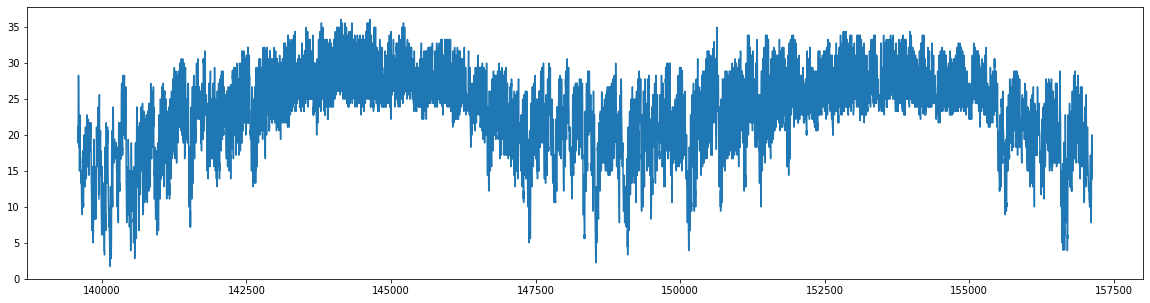

In [13]:
gator_temp_df.plot(figsize=(20,5))
plt.show()

In [16]:
sites = wet_df.site_id.unique()
wet_df.airTemperature

array(['Panther', 'Robin', 'Fox', 'Rat', 'Bear', 'Lamb', 'Peacock',
       'Moose', 'Gator', 'Bull', 'Bobcat', 'Crow', 'Shrew', 'Swan',
       'Wolf', 'Hog', 'Eagle', 'Cockatoo', 'Mouse'], dtype=object)

## Useful references

Jason Brownlee  
https://machinelearningmastery.com/arima-for-time-series-forecasting-with-python/